# Data Importing

In [3]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Changable_Parameter**

In [6]:
#here image size is 256x256
IMAGE_SIZE = 200
#every time process 32 images (61x31)~1951
batch_size = 10
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 25
NUM_CLASSES = 2
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=5
data_dir ="D:\\Pocs\\pocs"
split_folder = "D:\\Pocs\\split"
model_name="inception v3"   

**Directory Creation and split**

In [8]:
import os
import shutil
import random
import math

# Example paths

train_val_dir = os.path.join(split_folder, "train_validation_data")
test_dir = os.path.join(split_folder, "test_data")

def split_data(source_folder, split_folder, train_val_ratio=0.9):
    # Check if split folders already exist
    if os.path.exists(train_val_dir) and os.path.exists(test_dir):
        print("Split folders already exist. Skipping data split.")
        return
    
    # Create split folders if they do not exist
    if not os.path.exists(split_folder):
        os.makedirs(split_folder)
    if not os.path.exists(train_val_dir):
        os.makedirs(train_val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Count variables
    train_val_count = 0
    test_count = 0
    
    # Iterate through source_folder (main folder with classes)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        
        if os.path.isdir(class_path):
            # Create corresponding folders in split_folder
            train_val_class_path = os.path.join(train_val_dir, class_folder)
            test_class_path = os.path.join(test_dir, class_folder)
            
            if not os.path.exists(train_val_class_path):
                os.makedirs(train_val_class_path)
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)
            
            # List all images in the class folder
            images = [img for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png')]
            random.shuffle(images)
            
            # Calculate split indices
            split_index = int(len(images) * train_val_ratio)
            
            # Split images into train_validation_data and test_data
            train_val_images = images[:split_index]
            test_images = images[split_index:]
            
            # Copy images to respective split folders
            for img in train_val_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(train_val_class_path, img)
                shutil.copy(src, dst)
                train_val_count += 1
                
            for img in test_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(test_class_path, img)
                shutil.copy(src, dst)
                test_count += 1
    
    print("Data split completed successfully.")
    print(f"Number of images in train_validation_data: {train_val_count}")
    print(f"Number of images in test_data: {test_count}")
    print(f"Total number of images: {train_val_count + test_count}")

# Call the function with your paths
split_data(data_dir, split_folder)


Split folders already exist. Skipping data split.


In [9]:
import os
import shutil
import random
import tensorflow as tf
# Define image parameters

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.10+.03,  # 10% of the data will be used for validation
)

train_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


validation_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical'  # Update for multi-class classification
)


Found 3009 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Found 386 images belonging to 2 classes.


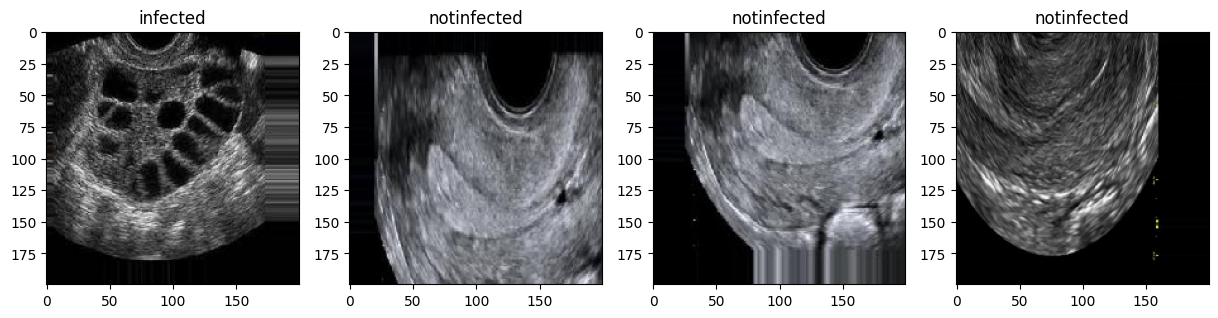

In [10]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, batch_size)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [12]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L

model= InceptionV3(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

**Fine Tuning**

In [14]:
for layer in model.layers[:168]:
   layer.trainable = False
for layer in model.layers[168:]:
   layer.trainable = True

# # print('Last block of the conv_base is now trainable')


# for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

In [15]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    #top_model = Dropout(0.6)(top_model) 
    #top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [16]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)
#print(model.summary())

# Training

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 5:
         return .0009
     else:
        return .0009

lr_scheduler = LearningRateScheduler(scheduler)

In [19]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [21]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [22]:


model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/25
301/301 [==============================] - ETA: 0s - loss: 1.9891 - accuracy: 0.9867
Epoch 1: val_loss improved from inf to 0.04478, saving model to Model\inception v3_Model.hdf5
301/301 [==============================] - 40s 105ms/step - loss: 1.9891 - accuracy: 0.9867 - val_loss: 0.0448 - val_accuracy: 1.0000 - lr: 9.0000e-04
Epoch 2/25
301/301 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9937
Epoch 2: val_loss improved from 0.04478 to 0.02413, saving model to Model\inception v3_Model.hdf5
301/301 [==============================] - 22s 73ms/step - loss: 0.0900 - accuracy: 0.9937 - val_loss: 0.0241 - val_accuracy: 1.0000 - lr: 9.0000e-04
Epoch 3/25
301/301 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9934
Epoch 3: val_loss improved from 0.02413 to 0.01576, saving model to Model\inception v3_Model.hdf5
301/301 [==============================] - 22s 73ms/step - loss: 0.0753 - accuracy: 0.9934 - val_loss: 0.0158 - val_accur

**saving models**

In [24]:
import pickle

pickle_path_json = os.path.join("Results", f"{model_name}_model_architecture.json")
pickle_model_path = os.path.join("Model", f"{model_name}_model_pickle.pkl")

# Save model architecture to JSON (only needed once)
model_architecture = model.to_json()
with open(pickle_path_json, 'w') as f:
    f.write(model_architecture)

# Save model weights using pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://888ff3b5-b0d6-449a-87ed-056dc70b7cdd/assets


In [25]:
model.save(f'{model_name}_.h5')

In [26]:
model = tf.keras.models.load_model(f'{model_name}_.h5')

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Result

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

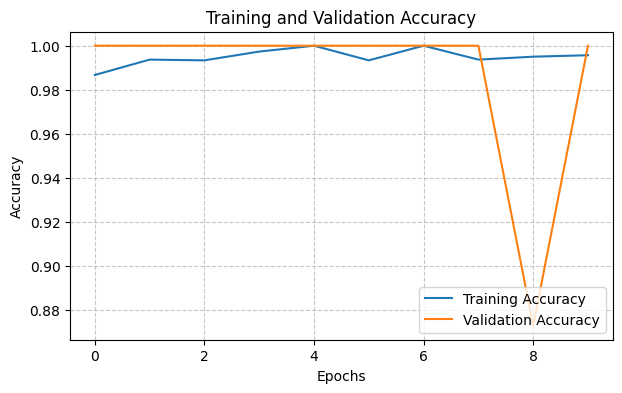

In [30]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

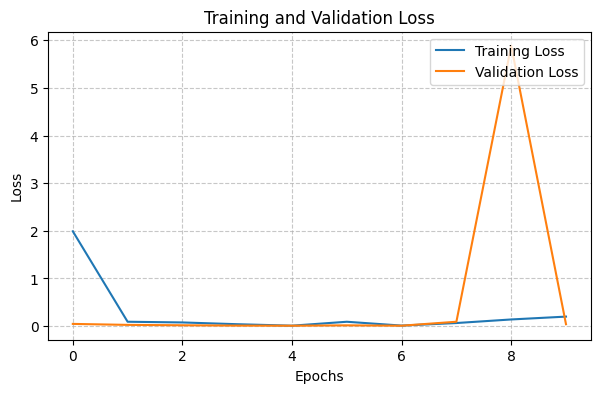

In [31]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

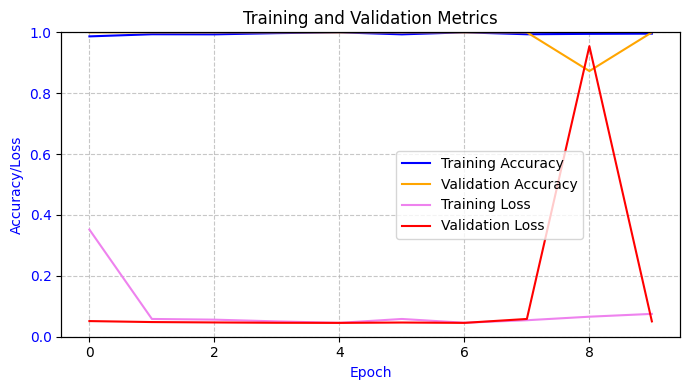

In [32]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# epochs: list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
# history: training history object containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss' metrics

fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot Training and Validation Accuracy
ax1.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Set y-axis label and limits for accuracy
ax1.set_ylabel('Accuracy/Loss', color='blue')
ax1.set_xlabel('Epoch', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 1])  # Limit y-axis for accuracy between 0 and 1

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], label='Training Loss', color='violet')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')

# Hide y-axis ticks and labels for loss
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_ylabel('')  # Set empty string to hide the label

# Add grid, legends, title, and x-axis label
ax1.grid(True, linestyle='--', alpha=0.7)

# Combine legends for accuracy and loss in the middle right
handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Adjust legend position to be slightly left of center right
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.85, 0.5))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show plot
plt.tight_layout()
plt.show()


In [33]:
score = model.evaluate(test_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

39/39 [==============================] - 3s 62ms/step - loss: 0.0383 - accuracy: 1.0000
Test Loss: 0.03828059881925583
Test accuracy: 100.0


In [34]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=class_labels, zero_division=1,digits=4)



In [35]:
print(report)

              precision    recall  f1-score   support

    infected     1.0000    1.0000    1.0000       157
 notinfected     1.0000    1.0000    1.0000       229

    accuracy                         1.0000       386
   macro avg     1.0000    1.0000    1.0000       386
weighted avg     1.0000    1.0000    1.0000       386



In [36]:
pip install numpy --upgrade


  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [37]:
pip install pandas scikit-image seaborn


Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install numpy==1.21.1

  Using cached numpy-1.21.1-cp38-cp38-win_amd64.whl.metadata (2.0 kB)
Using cached numpy-1.21.1-cp38-cp38-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


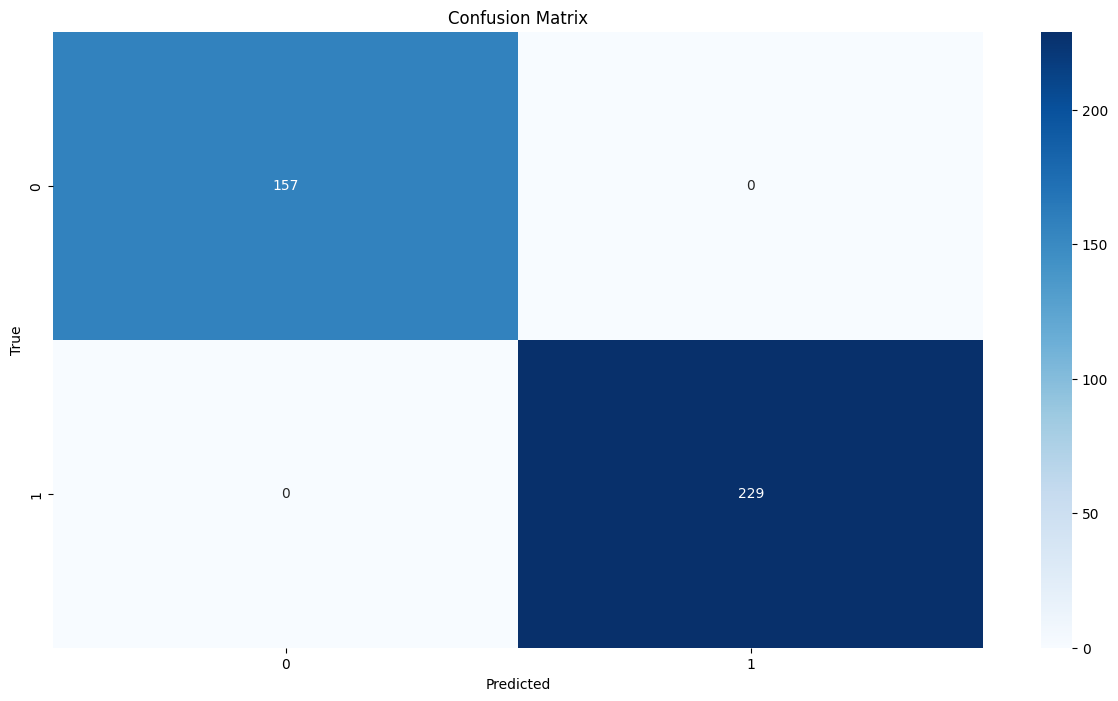

In [39]:
cm = confusion_matrix(y_true_all, y_pred_all)
import seaborn as sns
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# Plot confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

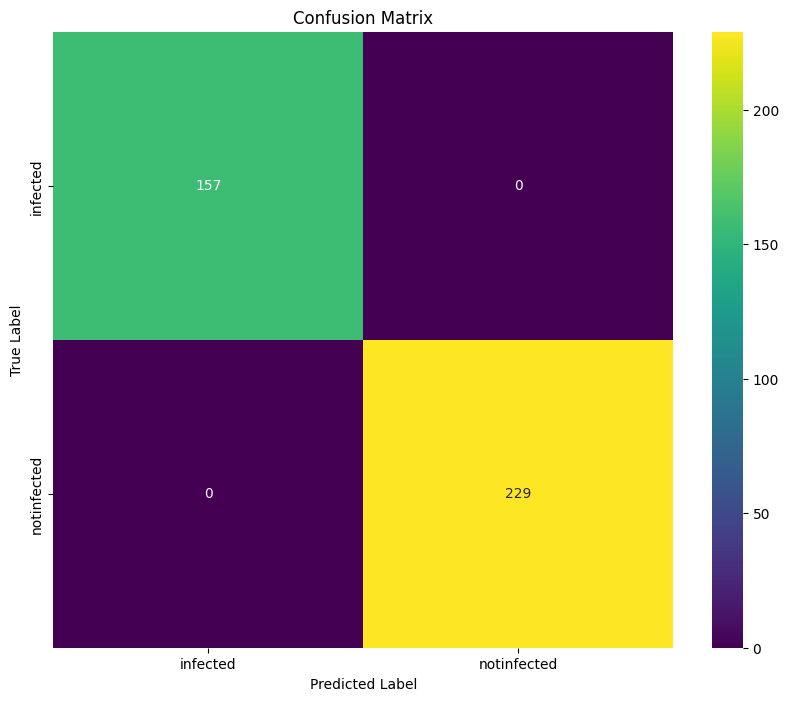

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Plot confusion matrix with a colorful palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [41]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

(386, 2)

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
labels = list(test_generator.class_indices.keys())

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

Error in generating ROC curve for infected. Dataset lacks enough examples.
Error in generating ROC curve for notinfected. Dataset lacks enough examples.


<Figure size 640x480 with 0 Axes>

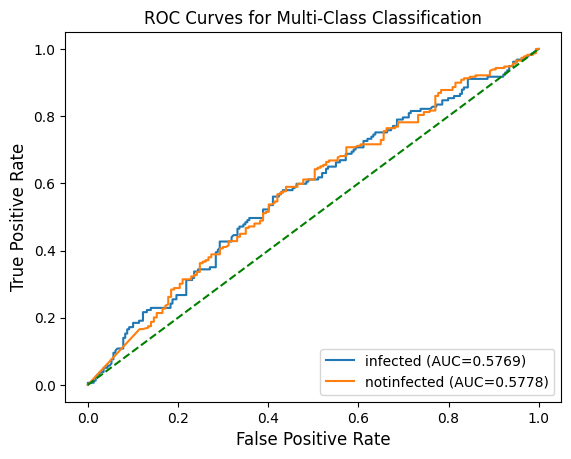

infected: ROC AUC = 0.5769
notinfected: ROC AUC = 0.5778


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming the following are defined:
# test_generator: the data generator for test data
# model: the trained model

# Predict probabilities for the test data
y_proba = model.predict(test_generator)
y_true = test_generator.classes  # True labels

# Get the class labels
labels = list(test_generator.class_indices.keys())

# Initialize dictionary to store AUC values for each class
roc_auc_ovr = {}

# Convert the true labels to one-hot encoding
y_true_one_hot = np.eye(len(labels))[y_true]

# Plot the ROC Curves One vs Rest
for i in range(len(labels)):
    # Get the class name
    c = labels[i]

    # Compute ROC curve and AUC for the current class
    fpr, tpr, _ = metrics.roc_curve(y_true_one_hot[:, i], y_proba[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_ovr[c] = roc_auc

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{c} (AUC={roc_auc:.4f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], color='green', linestyle='dashed')

# Add labels and legend
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.title('ROC Curves for Multi-Class Classification')
plt.show()

# Print overall AUC scores for each class
for class_name, auc_score in roc_auc_ovr.items():
    print(f'{class_name}: ROC AUC = {auc_score:.4f}')

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming the following are defined:
# test_generator: the data generator for test data
# model: the trained model

# Predict probabilities for the test data
y_proba = model.predict(test_generator)
y_true = test_generator.classes  # True labels

# Get the class labels
labels = list(test_generator.class_indices.keys())

# Initialize dictionary to store specificity values for each class
specificity_ovr = {}

# Function to calculate specificity from confusion matrix
def calculate_specificity(cm):
    # For binary classification, cm[0,0] is TN, cm[0,1] is FP, cm[1,0] is FN, cm[1,1] is TP
    # For multi-class, we use the confusion matrix in a specific way to get TN and FP for each class
    # Here, we calculate specificity for the negative class (index 0 in our case)
    true_negative = cm[0, 0]  # TN
    false_positive = cm[0, 1]  # FP
    specificity = true_negative / (true_negative + false_positive + 1e-10)  # Adding a small epsilon to avoid division by zero
    return specificity

# Compute confusion matrix and specificity for each class
for i in range(len(labels)):
    # Get the class name
    c = labels[i]

    # Get predictions and true labels for the current class
    y_pred_class = np.argmax(y_proba, axis=1)
    y_true_class = np.where(y_true == i, 1, 0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Calculate specificity for the current class
    specificity = calculate_specificity(cm)

    # Store the specificity value
    specificity_ovr[c] = specificity

# Print specificity scores for each class
for class_name, specificity in specificity_ovr.items():
    print(f'{class_name}: Specificity = {specificity:.4f}')


infected: Specificity = 0.4061
notinfected: Specificity = 0.4076
